# Feature Engineering
The goal of feature engineering is to create new predictive features that improve model estimates. So far we have engineered multiple features. For example, NDVI is a feature engineered from the red and near infrared portions of the electromagnetic spectrum. Likewise, SAVI, greeness, wetness, brightness, etc. are all engineered features derived from band cell values and a series of coefficients. While we could create various additional metrics from band cell values, in this example we will focus our attention on focal and convolution analyses to create new features.

- What is focal analysis?
- What is convolution analysis? 

## Focal analysis
Focal analyses use a moving window to summarize cell values within a defined region and attribute the center (focal) cell with that summarized value. Common summary statistics calculated using focal analyses include: sum, mean, standard deviation, variance, unique counts, entropy, angular second moments, asm, max, min, median, and mode. Below is an example of how the sum focal analyses works for a 3 by 3 window. Each focal cell (red) in the output raster will be the summed values of the cells within the analysis window (blue cells).

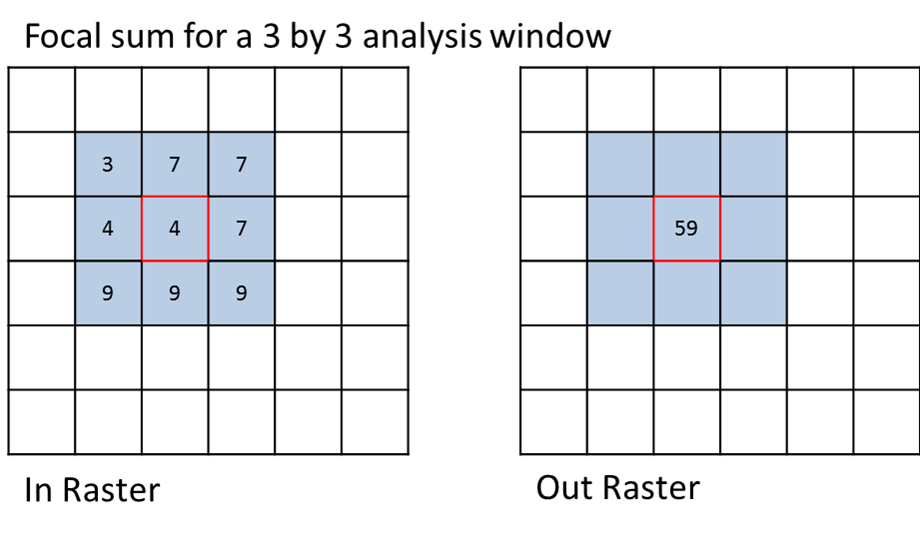

## Convolution analysis
Convolution analysis is similar to focal analysis in that it uses a neighborhood moving window to perform the analysis. However, user also define a kernel of values that are used to calculate the summed product of cells within that window. Using convolution kernels one can quantify various relationships among neighboring cell values. Below is a depiction of how convolution analyses are performed.

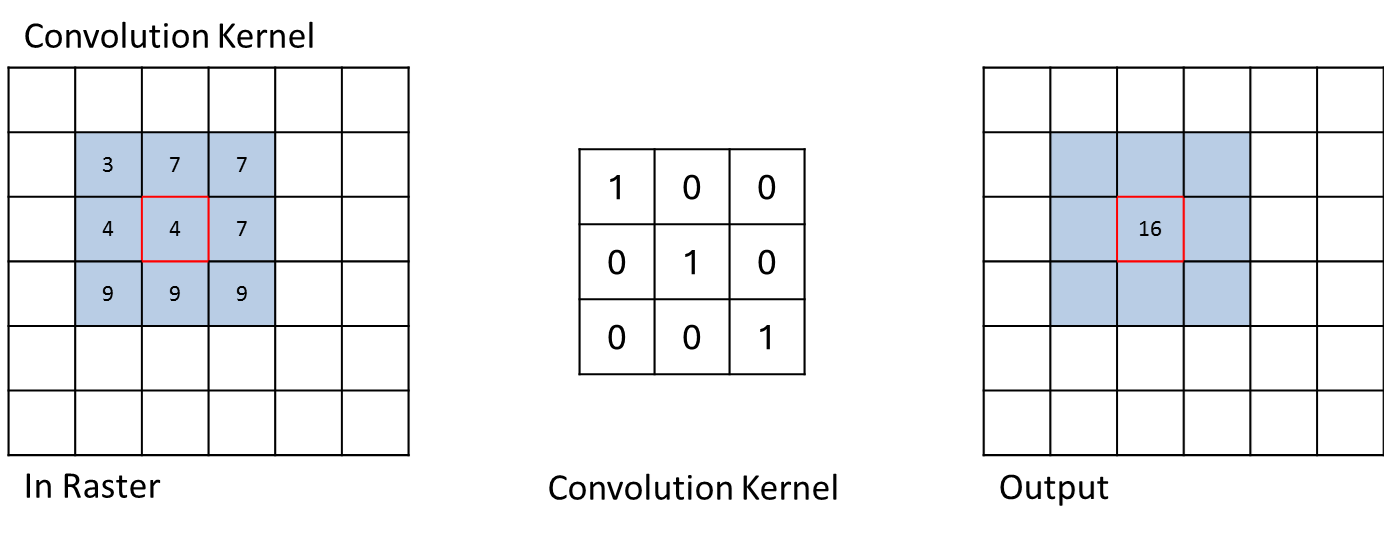

## Engineered Features
We will be using the [Raster Tools](https://github.com/UM-RMRS/raster_tools) package to perform focal and convolution analyses. **If you have not already worked through the [Getting The Imagery notebook](./GettingTheImagery.ipynb), please work through that notebook and create the medoid_subset.tif before continuing.** The features we will be engineering include mean, standard deviation, and edge features for each band of our medoid_subset.tif predictor images. Once created, we can use sample locations to extract the cell values associated with our engineered surfaces and use those value as predictor variables for modeling. Moreover, once we have created our models we can then apply them back to our engineered surfaces to create a surface of various response variables. 

In [ ]:
#import raster tools
from raster_tools import Raster, focal, zonal, general
import geopandas as gpd, shapely, pandas as pd

#### Let's look at a red, green, blue rendering of the medoid image subset.
Remember the mediod image has 6 bands (blue, green, red, nir, swir1, swir2)

In [ ]:
medoid_sub_rs=Raster('medoid_subset.tif')
rgb=medoid_sub_rs.get_bands([3,2,1]) #subset rearrange the bands so we get rgb
rgb.xdata.plot.imshow(robust=True,figsize=(15,12)) #plot the image



### What is the distance between each subplot for each plot? 
Let's look at how many cells make up a plot

In [ ]:
#get the plots and subplots
plot_sub=gpd.read_file('../Costa_Rica_Data/Classification_Plots.zip')

Subset the points to the boundary of the image

In [ ]:
#get the boundary of the  image
img_bnd=gpd.GeoSeries(shapely.box(*rgb.bounds),crs=rgb.crs)

#get all points inside the boundary
pint=plot_sub.loc[plot_sub.intersects(img_bnd.to_crs(plot_sub.crs).unary_union)].to_crs(rgb.crs)

#plot the first band and first plot
m=(pint.iloc[0:9,:]).explore(color='red',figsize=(15,12))
rgb.explore(band=1,map=m, robust=True)



## Exercise 1: interpreting distance
- How many cells apart are the subplots?
- What projection are we using?
- What happens to the number of cells if we project the data to a different projection?
- With regard to distance and area, does it matter what projection you are using?
- What size analysis window would make sense if you wanted to perform convolution or focal analyses to capture neighboring cell values 

## Creating new features
### Let's perform a 3 by 3 focal mean and standard deviation analysis and a 3 by 3 Laplacian convolution filter.
We have already extracted the cell value for each subplot and we have created features using linear transformations of cell band values (e.g., NDVI). Now let's create features using surrounding pixel values. There are many ways to accomplish this but for ease, let's use focal and convolution analyses to make new features that take into account surrounding cell values. So one of the questions we might have is, how big of a window should we use? When interpreting the distance between subplots it is obvious that if we reach too far out there will be a lot of duplicated information. So to begin with, let's use a 3 by 3 analysis window.   

In [ ]:
# perform the focal analyses using raster tools
fm33=focal.focal(medoid_sub_rs,'mean',3,3)
fs33=focal.focal(medoid_sub_rs,'std',3,3)

# perform Laplacian convolution analysis using raster tools
ce33=focal.convolve(medoid_sub_rs,[[0,1,0],[1,-4,1],[0,1,0]])

#### Let's visualize the 3 by 3 outputs for the RGB channels

In [ ]:
rgbm=fm33.get_bands([3,2,1]) #subset rearrange the bands so we get rgb
rgbm.xdata.plot.imshow(robust=True,figsize=(15,12)) #plot the image

rgbs=fs33.get_bands([3,2,1]) #subset rearrange the bands so we get rgb
rgbs.xdata.plot.imshow(robust=True,figsize=(15,12)) #plot the image

rgbe=ce33.get_bands([3,2,1]) #subset rearrange the bands so we get rgb
rgbe.xdata.plot.imshow(robust=True,figsize=(15,12)) #plot the image

## Exercise 2: interpreting the new feature surfaces
- Why did we use a 3 by 3 window?
- What is emphasized with the mean, standard deviation, and Laplacian analyses?
- How many different features have we created?
- How can we convert our new feature surfaces to features in our data frame?

## Extracting focal and convolution values and creating a features within our dataframe.
### Let's sample the cell values for the points within the boundary of the image using Raster Tools' zonal module.

In [ ]:
# let's create a stack of our 3 new feature surfaces.
nh_pred=general.band_concat([fm33,fs33,ce33])

#let's extract the cell values from n_pred
nh_pred_tbl=zonal.extract_points_eager(points=pint,raster=nh_pred,column_name='nh',axis=1).compute()

#display the data table
display(nh_pred_tbl)

#merge the data_table with the points
pint_pred=pd.concat([pint.reset_index(drop=True),nh_pred_tbl],axis=1) #reset the index for merging correctly

#visualize the point values
pint_pred.explore(column='nh_2')


## Exercise 3: Interpreting Features
- How many new features have we created?
- What other types of features can we create with convolution and focal analyses?
- Check out [GLCMs](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html). Would these be good features to create?
- If we were to use all Google Earth Engine surfaces as inputs to the focal and convolution analyses, how many features would you have in your models?
- If we make a model using existing or new features, how can we apply them to create a predictive surface (check out [model_predict function in Raster Tools](https://um-rmrs.github.io/raster_tools/reference/generated/raster_tools.general.model_predict_raster.html#raster_tools.general.model_predict_raster) and the [general module example notebook](https://github.com/UM-RMRS/raster_tools/blob/main/notebooks/general_module.ipynb)).
- Task 1: extract mean, standard deviation, and Laplacian features for all subplot locations.
- Task 2: make new features for the summarized plots.